# Imports

In [1]:
import glob
import os
from itertools import product

import modin.pandas as pd

# import dask.dataframe as pd
import plotly.express as px
import ray
from tqdm.auto import tqdm

ray.shutdown()
ray.init()

2022-07-24 05:06:39,479	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8266


RayContext(dashboard_url='127.0.0.1:8266', python_version='3.10.5', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '192.168.31.219', 'raylet_ip_address': '192.168.31.219', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-24_05-06-37_320833_5454/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-24_05-06-37_320833_5454/sockets/raylet', 'webui_url': '127.0.0.1:8266', 'session_dir': '/tmp/ray/session_2022-07-24_05-06-37_320833_5454', 'metrics_export_port': 60294, 'gcs_address': '192.168.31.219:60071', 'address': '192.168.31.219:60071', 'node_id': 'cdf15b02055f045f72eabac624063ac187d810bd884f6eb11a69238d'})

# Split the data

Put the data in folder `data`. Extract every file in the folder with the same name. If needed, adapt the path.

In [2]:
tsv_paths = sorted(
    glob.glob("data/NSDUH_Versions/*/*/*.tsv")
    + glob.glob("data/NSDUH_Versions/*/*/*/*.tsv")
)
tsv_paths_full = [path for path in tsv_paths if "Tab" in path]
tsv_paths = [
    path
    for path in tsv_paths
    if "Tab" not in path and any(f"{year}.tsv" in path for year in range(2002, 2015))
]

# tsv_paths

In [3]:
version_mapping = {
    "2002-2014": "1",
    "2002-2015": "2",
    "2002-2017": "3",
    "2002-2018": "4",
    "2002-2019": "5",
}

/home/astadnik/.virtualenvs/masters/lib/python3.10/site-packages/modin/pandas/dataframe.py:155: UserWarning:

Distributing <class 'list'> object. This may take some time.



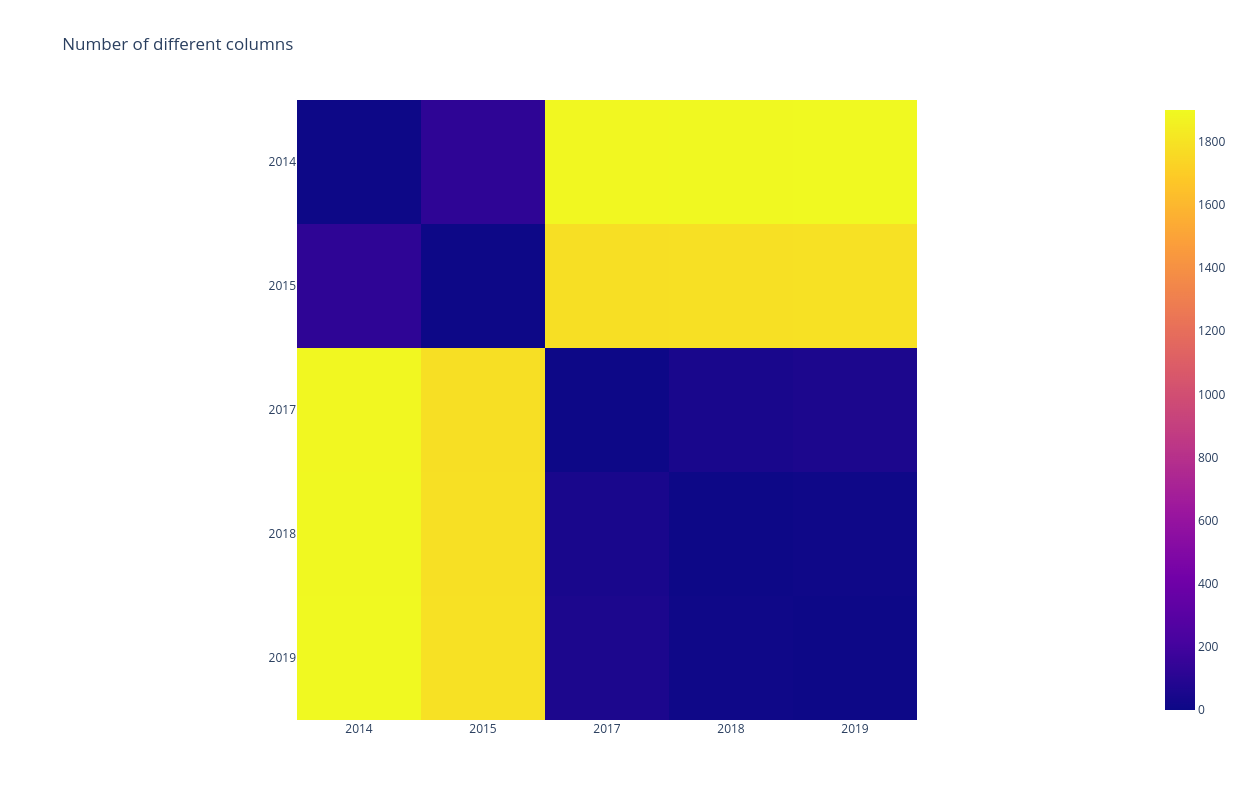

In [5]:
headers = []
for tsv_path in tsv_paths_full:
    with open(tsv_path, "r") as f:
        headers.append(next(f).split("\t"))

headers = [set(h) for h in headers]

diffs = [[h1 ^ h2 for h2 in headers] for h1 in headers]
n_diffs = [[len(v) for v in row] for row in diffs]
names = [str(year) for year in range(2014, 2020) if year != 2016]
px.imshow(
    pd.DataFrame(n_diffs, index=names, columns=names),
    title="Number of different columns", height=800
)

# Try all combinations

In [ ]:
numbers = {year: {} for year in range(2002, 2015)}

for tsv_path in tqdm(tsv_paths):
    parent_dir = os.path.dirname(tsv_path)
    with open(os.path.join(parent_dir, "schema.txt"), "r") as f:
        dtype = eval(f.read())
        dtype = {k: v if v != int else float for k, v in dtype.items()}
    df = pd.read_csv(tsv_path, sep="\t", dtype=dtype)

    year = int(tsv_path.split("/")[-1].removesuffix(".tsv"))
    version = None
    for pat, v in version_mapping.items():
        if pat in tsv_path:
            version = v
            break
    assert version is not None

    if pd.api.types.is_object_dtype(df["AGE2"].dtype):
        df["AGE2"] = pd.to_numeric(df["AGE2"].str.split().str[0], errors="coerce")
        df = df[df["AGE2"].notna()]
    numbers[year][version] = df[df["AGE2"] <= 10].shape[0]

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
numbers = [[v for v in vals.values()] for vals in numbers.values()]

from itertools import product

for combination in product(*numbers):
    if sum(combination) == 275_559:
        print(combination)